In [4]:
from keras import models
from keras import layers

def build_model(train_data):
    model =  models.Sequential()
    model.add(layers.Dense(64, activation='relu',  input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [5]:
import numpy as np

def k_cross_validation(train_data, train_targets):
    k=4
    
    num_val_samples = len(train_data) // k
    num_epochs = 50
    
    all_scores = []
    all_mae_histories = []

    for i in range(k):
        # print('Run #', i)
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

        model = build_model(train_data)
        
        history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        mae_history = history.history['val_mean_absolute_error']

        all_scores.append(val_mae)
        all_mae_histories.append(mae_history)

    print('scores from cross-validation: ', all_scores)
    print('mean all scores: ', np.mean(all_scores))

    # return average_mae_history
    return [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

scores from cross-validation:  [2.1351391985864923, 2.369717522422866, 2.584068229883024, 2.4249959700178394]
mean all scores:  2.3784802302275554


Text(0,0.5,'Mean absolut error - Validation')

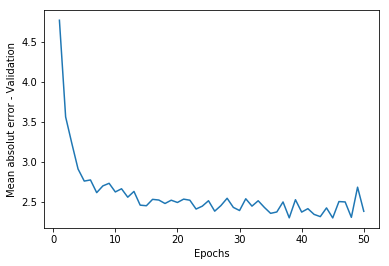

In [6]:
from keras.datasets import boston_housing
import matplotlib.pyplot as plt

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

# normalize data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean # TODO could we calculate the mean and std from test_data itself?
test_data /= std

average_mae_history = k_cross_validation(train_data, train_targets)

plt.figure()
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Mean absolut error - Validation')